In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import HuberRegressor

### Robustez

In [2]:
df = pd.read_csv('robustez.csv')

In [3]:
df.head()

,Unnamed: 0,xx,yy
0,1,4,9.968515
1,2,5,11.007480
2,3,6,11.992446
3,4,7,12.975716
4,5,8,13.969277


In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
model = LinearRegression()
model.fit(df['xx'].values.reshape(-1, 1), df['yy'])

LinearRegression()

Primero tratamos con una regresión clásica

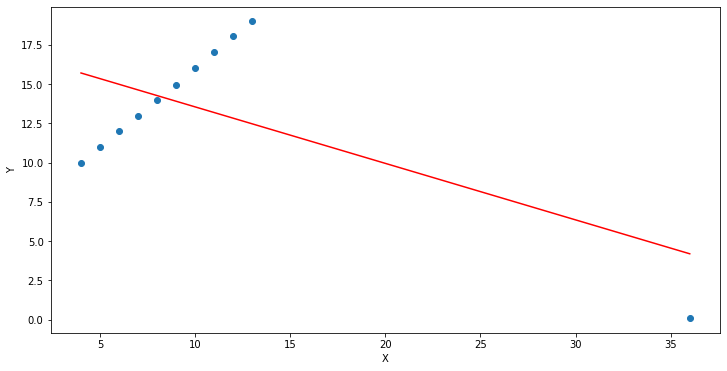

In [6]:
life_pred = model.predict(df['xx'].values.reshape(-1, 1))
fig = plt.figure(figsize=(12, 6))
plt.scatter(df['xx'], df['yy'])
plt.plot(df['xx'], life_pred, color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Como podemos ver, la recta ajustada es muy mala, veamos ahora que sucede con una regresión robusta mediante la función de Huber para calcular la pérdida.


### REVISAR ESTO, HUBER FITEA MAL Y RARO PERO RANSAC BIEN, SACAMOS O MANTENEMOS?

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
huber = SGDRegressor(loss='huber').fit(df['xx'].values.reshape(-1, 1), df['yy'])

In [9]:
from sklearn.linear_model import RANSACRegressor

In [10]:
huber = RANSACRegressor(residual_threshold=15).fit(
    df['xx'].values.reshape(-1, 1), df['yy']
)

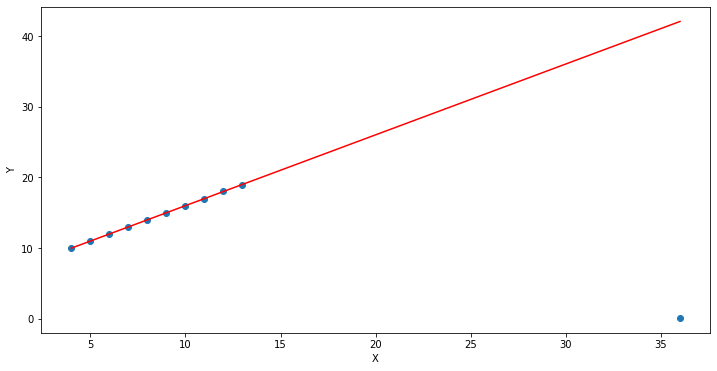

In [11]:
life_pred = huber.predict(df['xx'].values.reshape(-1, 1))
fig = plt.figure(figsize=(12, 6))
plt.scatter(df['xx'], df['yy'])
plt.plot(df['xx'], life_pred, color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

La recta esta mucho mejor ajustada, aunque todavía no es la ideal. Esto es debido a que la función de huber le resta importancia a los outliers pero no los elimina por completo

## Veamos ahora con un dataset con mas outliers

Para eso usaremos la libreria make_regression, la cual nos permite crear datos correlacionados positivamente

In [12]:
from sklearn.datasets import make_regression

In [13]:
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

Dibujamos los datos generados

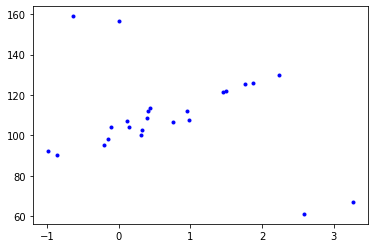

In [14]:

X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, 'b.')
plt.show()

Comenzamos por ajustar una regresión simple mediante la función de pérdida cuadrática (RSS)

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

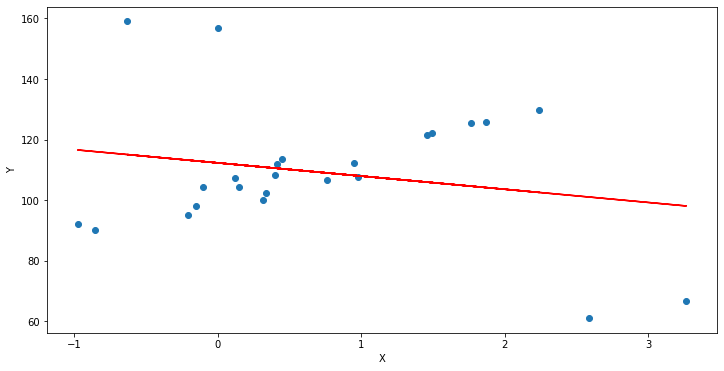

In [17]:
life_pred = model.predict(X)
fig = plt.figure(figsize=(12, 6))
plt.scatter(X, y)
plt.plot(X, life_pred, color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Veamos ahora como ajusta cambiando la función de pérdida por la función de huber y estableciendo un epsilon (K) de 1 (el mínimo valor posible)

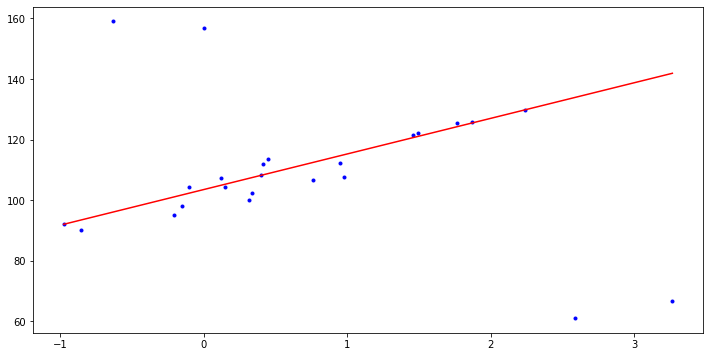

In [18]:

fig = plt.figure(figsize=(12, 6))
colors = ['r-', 'b-', 'y-', 'm-']
plt.plot(X, y, 'b.')

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)
plt.show()

Podemos observar que la recta ajustada es mucho mejor ya que le da poca importancia a los outliers

Veamos ahora que sucede si variamos los valores de epsilon

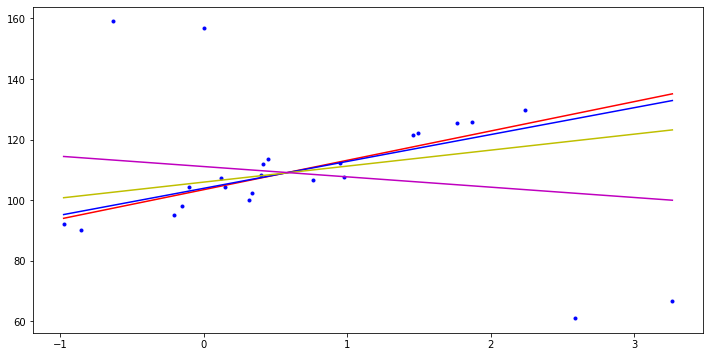

In [19]:

fig = plt.figure(figsize=(12, 6))
colors = ['r-', 'b-', 'y-', 'm-']
plt.plot(X, y, 'b.')

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1.35, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(fit_intercept=True, alpha=0.0, max_iter=100, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)
plt.show()

Podemos ver que a medida que epsilon crece el ajuste se vuelva subóptimo dado que los pesos de outliers empiezana  influenciar mas fuertemente al cáculo de los coeficientes

## Caso no lineal


Los datos <i>sinusoidales</i> son buenos ejemplos para comprobar los valores atípicos. Podemos hacer datos de entrenamiento y test  por separado. Los datos de test se pueden usar para verificar mse (error cuadrático medio) después del ajuste

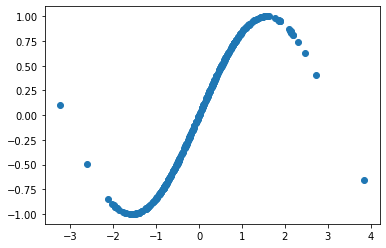

In [20]:

from sklearn.linear_model import (
    LinearRegression,
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

# Train data
X = np.random.normal(size=400)
y = np.sin(X)
X = X[:, np.newaxis]


# Test Data
X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

plt.scatter(X, y)

### Generando errores en X e Y
Para comprobar la robustez del modelo, pondremos valores atípicos en diferentes ejes y posiciones de X e Y. Luego veremos cómo responde cada modelo a varios valores atípicos. Crearemos 4 conjuntos de datos atípicos montados:

1. Pequeños valores atípicos en Y
2. Pequeños valores atípicos en X
3. Grandes valores atípicos en Y
4. Grandes valores atípicos en X

Text(0.5, 1.0, 'Grandes outliers en X')

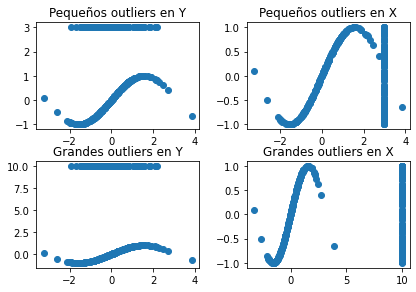

In [21]:
# Small outliers on Y
y_errors = y.copy()
y_errors[::3] = 3

# Small outliers on X
X_errors = X.copy()
X_errors[::3] = 3

# Small outliers on Y
y_errors_large = y.copy()
y_errors_large[::3] = 10

# Large outliers on X
X_errors_large = X.copy()
X_errors_large[::3] = 10

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.tight_layout()
ax[0, 0].scatter(X, y_errors)
ax[0, 0].set_title("Pequeños outliers en Y")

ax[0, 1].scatter(X_errors, y)
ax[0, 1].set_title("Pequeños outliers en X")

ax[1, 0].scatter(X, y_errors_large)
ax[1, 0].set_title("Grandes outliers en Y")

ax[1, 1].scatter(X_errors_large, y)
ax[1, 1].set_title("Grandes outliers en X")


### Definición de modelos

Ahora que tenemos nuestros datos listos, podemos construir modelos para una regresión robusta.

En lugar de ejecutar modelos individualmente, se pueden iterar utilizando for loop y scikit-learn pipeline. Para iterar, primero construiremos un diccionario que contiene instancias de los modelos, colores para trazarlos y sus estilos de línea. Por lo tanto, al usar esto, podemos trazar la línea de ajuste de todos los modelos en una sola gráfica.

In [22]:
estimators = [
    ('OLS', LinearRegression()),
    ('Theil-Sen', TheilSenRegressor(random_state=42)),
    ('RANSAC', RANSACRegressor(random_state=42)),
    ('HuberRegressor', HuberRegressor()),
]
colors = {
    'OLS': 'turquoise',
    'Theil-Sen': 'gold',
    'RANSAC': 'lightgreen',
    'HuberRegressor': 'black',
}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3
x_plot = np.linspace(X.min(), X.max())

En el siguiente loop:

1. El modelo se construye usando sklearn pipeline make_pipeline (PolynomialFeatures (3), estimator). Hemos usado PolynomialFeatures porque nuestros datos son sinosoidales y no se pueden ajustar usando una recta. Una vez generados los polinomios, se pasan al estimador definido en un diccionario.
2. El modelo se ajusta usando fit (this_X, this_y), donde this_X y this_y son datos de error pasados a través del bucle.
3. El rendimiento del modelo se calcula utilizando mean_squared_error sobre los datos de test (model.predict (X_test), y_test)
4. La Y pronosticada se calcula de forma simple utilizando model.predict (x_plot [:, np.newaxis]).


Después de construir, ajustar y predecir, los datos se trazan para cada uno de los modelos y para cada uno de los cuatro tipos de error.

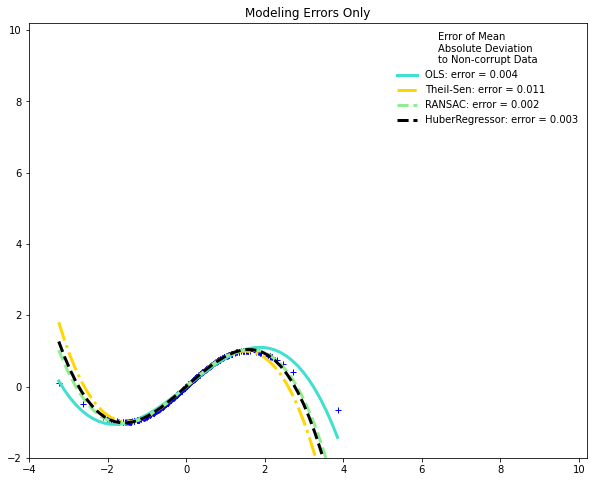

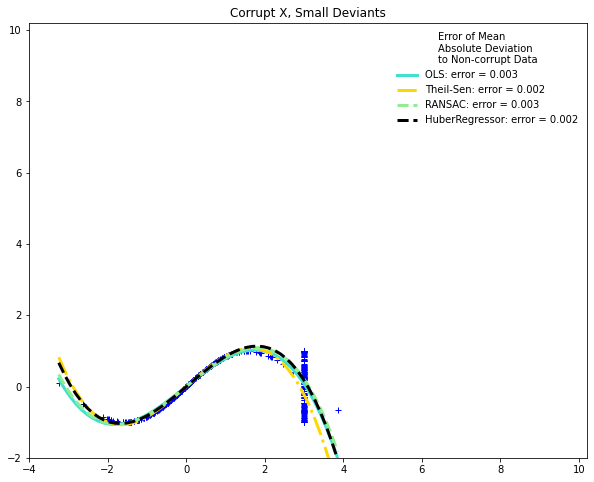

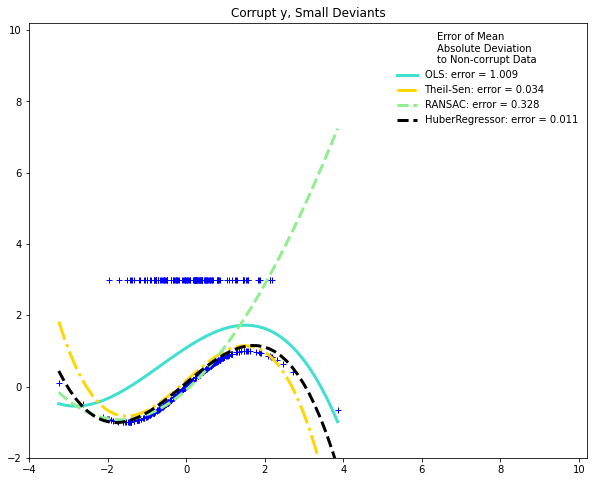

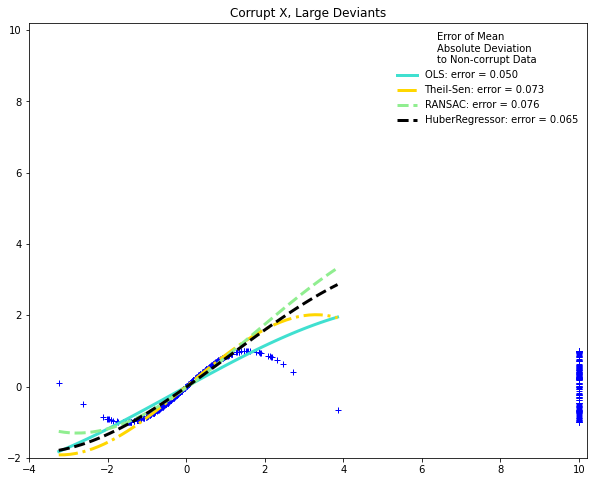

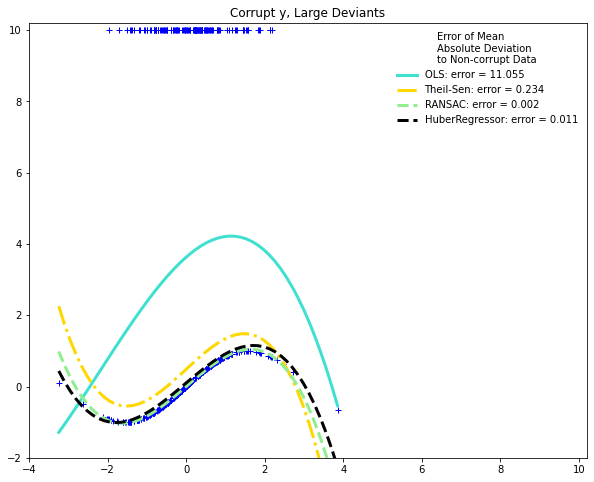

In [23]:
for title, this_X, this_y in [
    ('Modeling Errors Only', X, y),
    ('Corrupt X, Small Deviants', X_errors, y),
    ('Corrupt y, Small Deviants', X, y_errors),
    ('Corrupt X, Large Deviants', X_errors_large, y),
    ('Corrupt y, Large Deviants', X, y_errors_large),
]:
    plt.figure(figsize=(10, 8))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(
            x_plot,
            y_plot,
            color=colors[name],
            linestyle=linestyle[name],
            linewidth=lw,
            label='%s: error = %.3f' % (name, mse),
        )

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title)
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()

### Qué podemos inferir

* RANSAC es bueno para valores atípicos grandes en la dirección y.
* TheilSen es bueno para pequeños valores atípicos, tanto en la dirección X como en y, pero tiene un punto de quiebre por encima del cual se desempeña peor que OLS.
* Es posible que las puntuaciones de HuberRegressor no se comparen directamente con TheilSen y RANSAC porque no intenta filtrar completamente los valores atípicos, sino que reduce su efecto.

A pesar de un rendimiento superior sobre los modelos de mínimos cuadrados, los modelos robustos todavía no se utilizan ampliamente. Las razones son: La regresión robusta requiere cálculos pesados y, a veces, los valores atípicos son un requisito de un modelo.
